In [1]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, SamplingConfig, GenerationConfig
from esm.utils.constants.models import ESM3_OPEN_SMALL
import tqdm
import numpy as np
from Bio import SeqIO
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
login(token="")

In [3]:
client = ESM3.from_pretrained(ESM3_OPEN_SMALL).to("cuda")
# client = ESM3.from_pretrained("esm3-open").to("cuda")

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
# # Example:
# proteins = [
#     ESMProtein(
#         sequence="MFVDDVTRAFESGDFARPNLFEVEISYLGQNFSFQCRATALPAAIVEKVPVSYMNRKINVAGDRTFDDWTITVMNDDAHSIRQKFVDWQGIAAGQGNEITGGKPAEYKKSAIVRQFARDAKTVTKEVEIVGLWPTNVGEVSLDWDSNNEIETFEVTLALDWWE"
#     ),
#     ESMProtein(
#         sequence="MKFNILSLFAPWAKMDERDYKDQEKENLESITTPKLDDGAKEYEVSENEAQQTYNAMFQRMFGSQEPGLKSTRELIDTYRNLMTNYEVDNAVSEIVSDAIVYEDDTEVVSINLDNTKFSPNIKSMMLDEFNEVLNHLSFQRKGSDHFRRWYVDSRIFFHKIIDPKRPKEGIKELRRLDPRQVQYVREVITTTEAGVKIVKGYKEYFIYDTSHESYACDGRIYEAGTKIKIPKAAIVYAHSGLVDCCGKNIIGYLHRAIKPANQLKLLEDAVVIYRITRAPDRRVWYVDTGNMPSRKAAEHMQHVMNTMKNRIAYDATTGKIKNQQHIMSMTEDYWLQRRDGKAVTEVDTLPGADNTGNMEDVRWFRNALYMALRIPITRIPSDQGGIQFDAGTSITRDELSFGKFIRELQHKFEEIFLDPLKTNLILKGIITEDEWNDEINNIKIKFHRDSYFSELKDAEILERRINMLQMAEPFIGKYISHRTAMKDILQMSDEEIEQEAKQIEEESKEARFQDPDQEQEDF"
#     ),
#     ESMProtein(
#         sequence="MDDLIQAIKSNDLVATRKFFESAMAEKTVRLIEARKAEIASQFLIEGEEPEEEEKKASEDDADEGDDDEDEDDEDDE"
#     ),
# ]

# outputs = []
# for i, prot in enumerate(proteins):
#     print(f"Protein: {i}")
#     protein_tensor = client.encode(prot)
#     outputs.append(
#         client.forward_and_sample(
#             protein_tensor,
#             SamplingConfig(
#                 return_per_residue_embeddings=True, return_mean_embedding=True
#             ),
#         )
#     )

In [4]:
# Import BASEL proteins
df = pd.read_csv("classification_model/data/proteins_for_embeddings.csv")

print(df.head)

<bound method NDFrame.head of                                      id  \
0     NC_021316.1_prot_YP_008058193.1_1   
1     NC_021316.1_prot_YP_008058194.1_2   
2     NC_021316.1_prot_YP_008058195.1_3   
3     NC_021316.1_prot_YP_008058196.1_4   
4     NC_021316.1_prot_YP_008058197.1_5   
...                                 ...   
1147      MK473382.1_prot_QBJ05095.1_50   
1148      MK473382.1_prot_QBJ05096.1_51   
1149      MK473382.1_prot_QBJ05097.1_52   
1150      MK473382.1_prot_QBJ05098.1_53   
1151      MK473382.1_prot_QBJ05099.1_54   

                                               sequence  
0     MRQLADHINSTYLSKDVHSDGKLWVIFNHDGKDYQREVKFKPFSNF...  
1     MSNLNMPLAVLRPELTAEHKAKFKQLGFNEIDMSMEGEVSLILTDD...  
2     MNLLITVEDINKAIASISKRGKQLDNDIHVAGVSCLKHCDAHGDST...  
3     MEPTVKQLQDTIAQLNEALDNWDYVVVQDGALVQLPITKKVVDADR...  
4     MTDRKYDYQSHAHIPRWVTVKIVPYQMSKVVMIKSSKHTDWKDYRA...  
...                                                 ...  
1147  MTREEYFEKRQEMIDEAQKLLDDEIGEEGTGEGKTEEAEKI

In [ ]:
# Calculate protein sequence embeddings and save them as npy files


def get_esm_embedding(sequence):
    protein = ESMProtein(sequence=sequence)
    protein_tensor = client.encode(protein)

    result = client.forward_and_sample(
        protein_tensor,
        SamplingConfig(return_per_residue_embeddings=True, return_mean_embedding=True),
    )

    return result


def process_sequences(df):
    ids = []
    embeddings = []

    for index, row in tqdm.tqdm(
        df.iterrows(), total=len(df), desc="Processing protein sequences"
    ):
        seq = row["sequence"]
        protein_id = row["id"]

        seq = seq[:1500]  # Limit protein length
        embedding = get_esm_embedding(seq)
        ids.append(protein_id)
        embeddings.append(embedding)

    np.save("esm_embedding_protein_ids_class.npy", np.array(ids))
    np.save("esm_embedding_embeddings_class.npy", np.array(embeddings))


process_sequences(df)

Processing protein sequences:   1%|          | 12/1152 [00:14<23:26,  1.23s/it]


KeyboardInterrupt: 

In [6]:
# Load embeddings and get mean embeddings per residue (?)
mean_embeddings = []
esm_embeddings = np.load("esm_embedding_embeddings_fsHits.npy", allow_pickle=True)
mean_embeddings = [ebd.mean_embedding.cpu() for ebd in esm_embeddings]

# print(esm_embeddings[0])

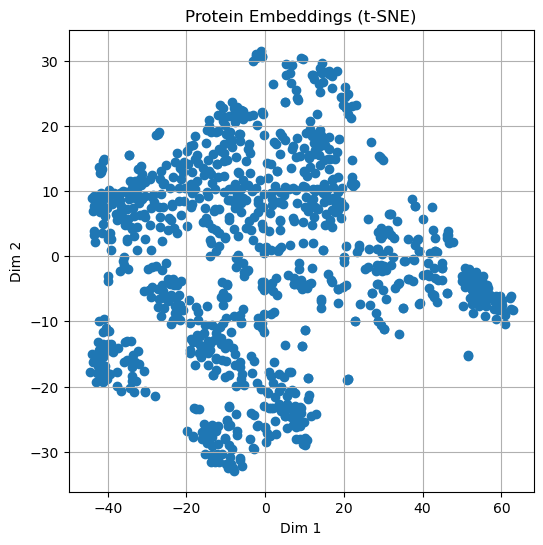

In [7]:
# Plot protein sequence embeddings

# Stack and convert to numpy array
stack_mean_embeddings = torch.stack([emb for emb in mean_embeddings]).numpy()

# t-SNE
perplexity = min(30, stack_mean_embeddings.shape[0] - 1)
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    random_state=42,
)
reduced = tsne.fit_transform(stack_mean_embeddings)  # Shape: (N, 2)
# print(reduced.shape)

# tsne Plot
plt.figure(figsize=(6, 6))
plt.scatter(reduced[:, 0], reduced[:, 1])

plt.title("Protein Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

For n_clusters = 9 The average silhouette_score is : 0.43000987
For n_clusters = 13 The average silhouette_score is : 0.4322267
For n_clusters = 14 The average silhouette_score is : 0.43473238


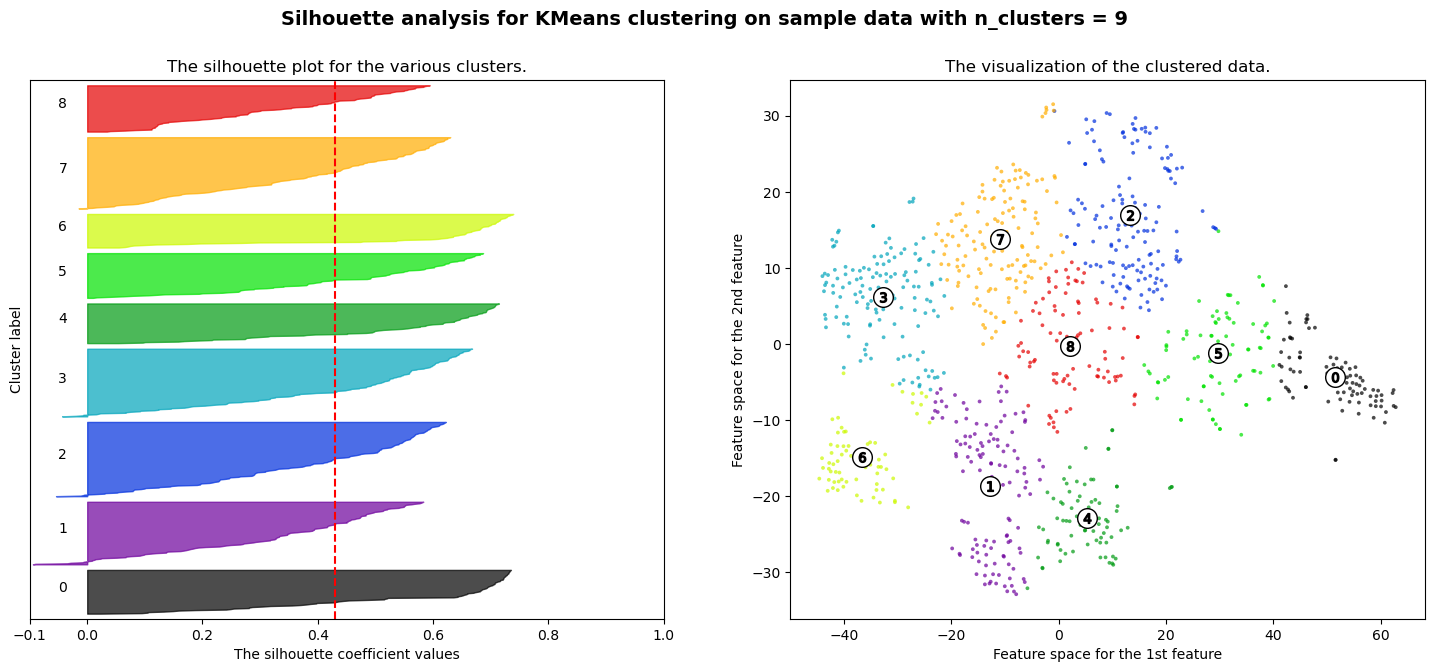

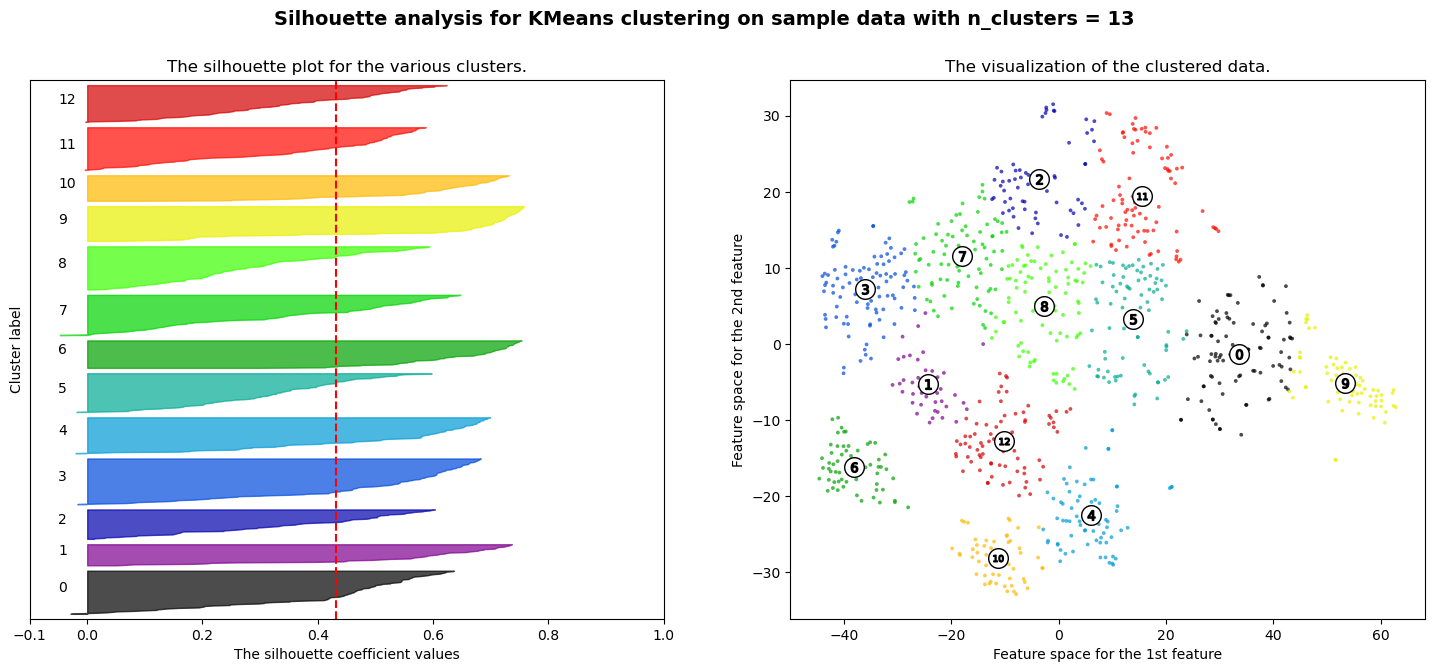

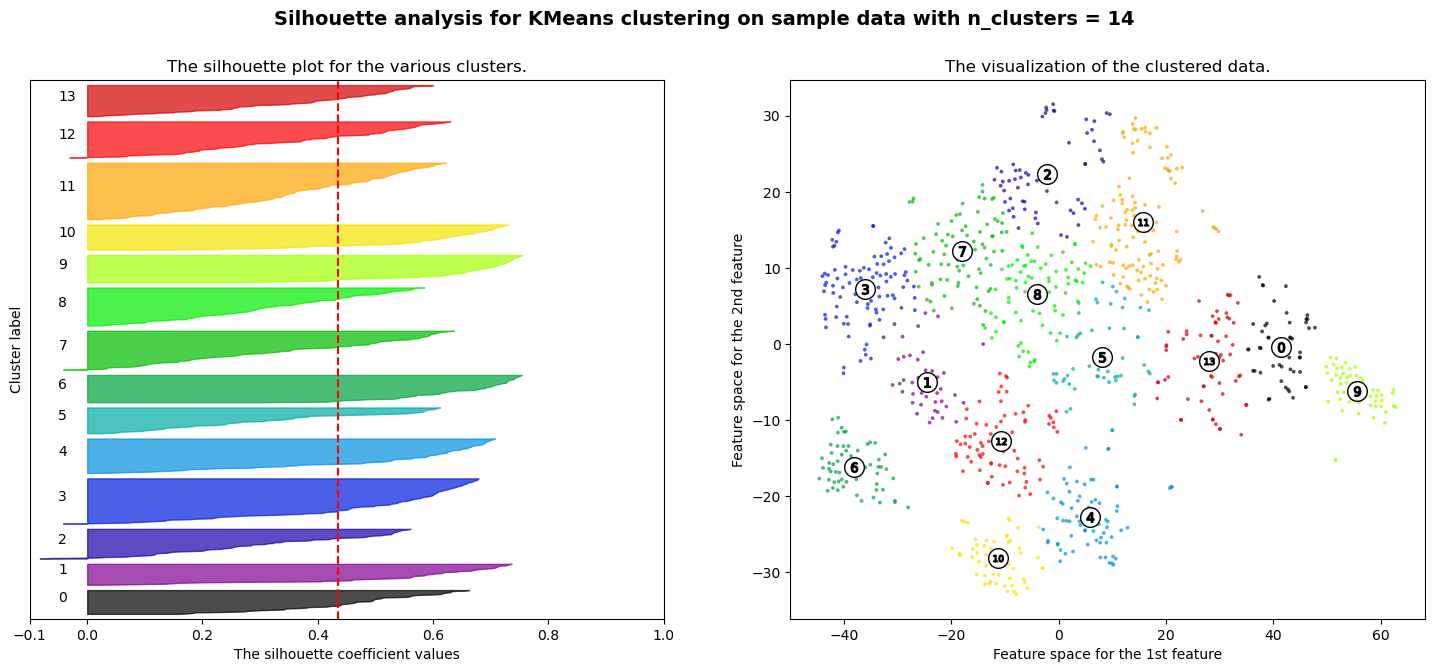

In [21]:
# Silhouette analysis to find optimal k
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [9, 13, 14]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        reduced[:, 0],
        reduced[:, 1],
        marker=".",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

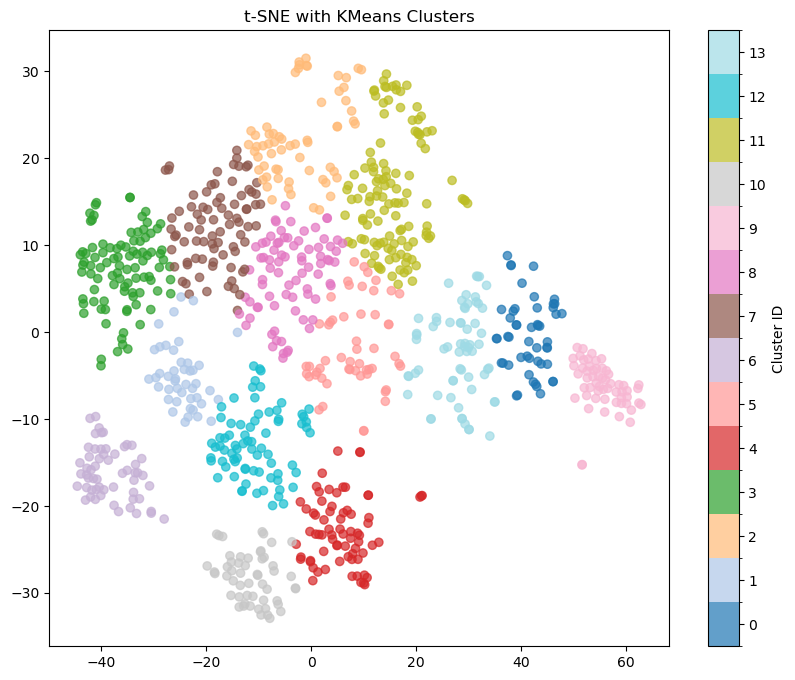

In [25]:
from sklearn.cluster import KMeans
from matplotlib.colors import BoundaryNorm

k = 14

clustering = KMeans(n_clusters=k, random_state=10).fit(reduced)
labels = clustering.labels_

# Define discrete colormap and normalization
cmap = plt.get_cmap("tab20", k)
norm = BoundaryNorm(np.arange(-0.5, k + 0.5), k)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced[:, 0], reduced[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7
)
plt.title("t-SNE with KMeans Clusters")

# Colorbar with all cluster labels
cbar = plt.colorbar(scatter, ticks=range(k))
cbar.set_label("Cluster ID")
cbar.set_ticklabels([str(i) for i in range(k)])

plt.show()

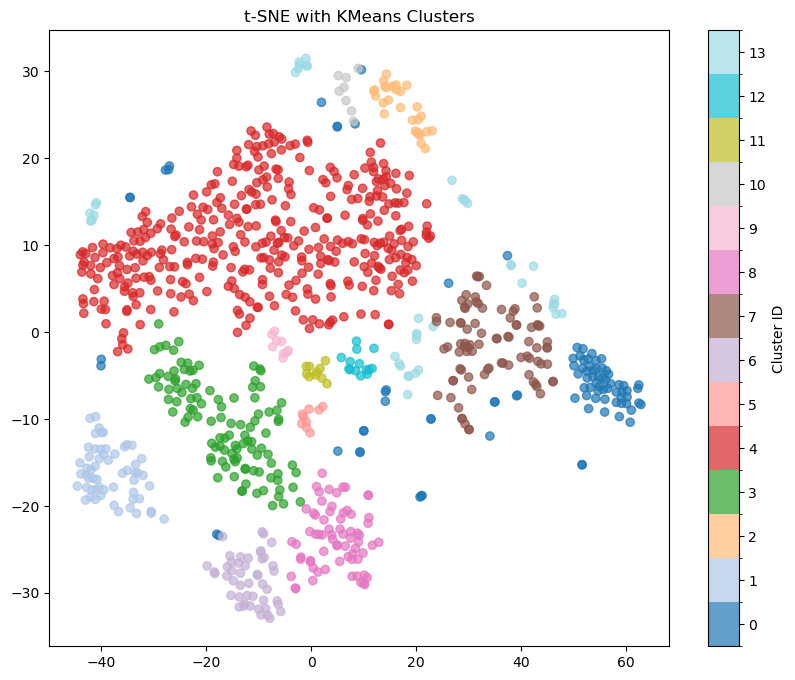

In [26]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=5).fit(reduced)
labels = clustering.labels_  # -1 means noise/outlier

cmap = plt.get_cmap("tab20", k)
norm = BoundaryNorm(np.arange(-0.5, k + 0.5), k)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced[:, 0], reduced[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7
)
plt.title("t-SNE with KMeans Clusters")

# Colorbar with all cluster labels
cbar = plt.colorbar(scatter, ticks=range(k))
cbar.set_label("Cluster ID")
cbar.set_ticklabels([str(i) for i in range(k)])

plt.show()

In [ ]:
ids = df["id"].copy()
df_clusters = pd.DataFrame(
    {
        "proteinID": ids,  ## Idk if this id order is correct (!)
        "tSNE1": reduced[:, 0],
        "tSNE2": reduced[:, 1],
        "cluster": labels,
    }
)
# print(df_clusters)

cluster_1 = df_clusters[df_clusters["cluster"] == 1]
print(cluster_1["proteinID"].size)
print(cluster_1["proteinID"].values)

8
['MZ501090.1_prot_QXV82342.1_89_unknown'
 'MZ501108.1_prot_QXV85120.1_50_unknown'
 'MZ501101.1_prot_QXV84079.1_80_unknown'
 'MZ501053.1_prot_QXV76566.1_84_unknown'
 'MZ501079.1_prot_QXV80766.1_91_unknown'
 'MZ501077.1_prot_QXV80625.1_90_unknown'
 'MZ501077.1_prot_QXV80605.1_70_unknown'
 'NC_073066.1_prot_YP_010741207.1_34_unknown']


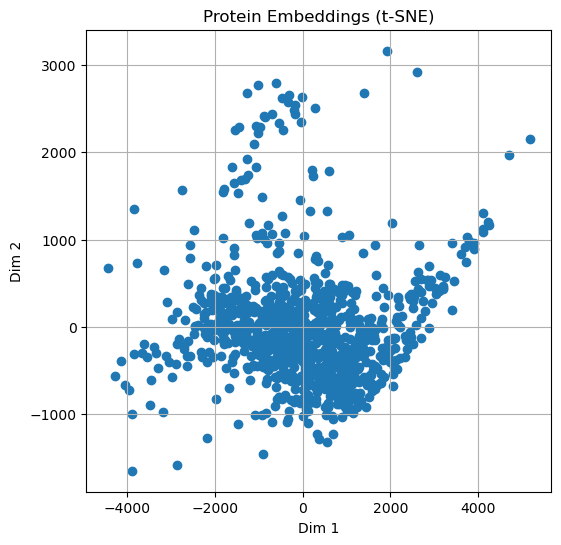

In [38]:
# PCA plot
pca = PCA(n_components=2)
components = pca.fit_transform(stack_mean_embeddings)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(components[:, 0], components[:, 1])

plt.title("Protein Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [27]:
# Folding
protein = ESMProtein(
    sequence="MTSEPKVYQIPRSQQRTFTLKLWAEQNKLCPLCGKPIDISVKGEAVMDHDHETGLVRGVLHRSCNTAEGKITNAAGSWGCKSMRYSDIIPYLHSLLAYLEGPKHPLIYPLHKTDEEKHEAKLAKRRQAAAKRKAAMAVAKHNARNV"
)
sequence_length = len(protein.sequence)  # type: ignore
num_steps = int(sequence_length / 16)
protein.coordinates = None
protein.function_annotations = None
protein.sasa = None
folded_protein = client.generate(
    protein,
    GenerationConfig(track="structure", schedule="cosine", num_steps=num_steps),
)
assert isinstance(folded_protein, ESMProtein), (
    f"ESMProtein was expected but got {protein}"
)
folded_protein.to_pdb("./gene-PPLUZ19_gp23.pdb")

100%|██████████| 9/9 [00:24<00:00,  2.77s/it]
/home/sam_linux/miniconda3/envs/pha/lib/python3.13/site-packages/esm/utils/structure/protein_complex.py:223: UserWarning: Entity ID not found in metadata, using None as default
  warnings.warn("Entity ID not found in metadata, using None as default")


In [28]:
# Function prediction
protein.function_annotations = None
protein_with_function = client.generate(
    protein,
    GenerationConfig(track="function", schedule="cosine", num_steps=20),
)
assert isinstance(protein_with_function, ESMProtein), (
    f"{protein_with_function} is not an ESMProtein"
)

100%|██████████| 20/20 [02:47<00:00,  8.39s/it]


In [ ]:
print(protein_with_function.function_annotations)
print(folded_protein.plddt)

[FunctionAnnotation(label='adenyl', start=18, end=74), FunctionAnnotation(label='adenyl nucleotide', start=18, end=74), FunctionAnnotation(label='adenyl ribonucleotide', start=18, end=74), FunctionAnnotation(label='amino', start=18, end=74), FunctionAnnotation(label='anion binding', start=18, end=74), FunctionAnnotation(label='atp binding', start=18, end=74), FunctionAnnotation(label='carboxylic', start=18, end=74), FunctionAnnotation(label='carboxylic acid', start=18, end=74), FunctionAnnotation(label='derivative binding', start=18, end=74), FunctionAnnotation(label='endonuclease', start=18, end=74), FunctionAnnotation(label='heterocyclic', start=18, end=74), FunctionAnnotation(label='heterocyclic compound', start=18, end=74), FunctionAnnotation(label='molecule binding', start=18, end=74), FunctionAnnotation(label='nucleotide binding', start=18, end=74), FunctionAnnotation(label='organic acid', start=18, end=74), FunctionAnnotation(label='oxoacid', start=18, end=74), FunctionAnnotatio